In [1]:
# Imports
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
import networkx as nx
from shapely.geometry import LineString, Point, Polygon, MultiPoint
from shapely.ops import nearest_points
from shapely.ops import unary_union
from shapely import speedups
from geopy.geocoders import Nominatim
from geopandas.tools import geocode
from geopy.extra.rate_limiter import RateLimiter
import datetime
import folium
import geojson

%matplotlib inline

## 1.
Travel times

Functioning locations: 
- Yliopistonkatu 3 = Porthania
- Haartmaninkatu 8 = Meilahti
- Gustaf Hällströmin katu 2 = Kumpula
- Viikinkaari 11 = Viikki

In [2]:
epsg=3067

In [3]:
# Test addresses
#orig_address = 'Radiokuja 6, 00240, Helsinki, Finland'
#dest_address = 'Väinö Auerin katu 13, 00560, Helsinki, Finland'

# Test addresses2 and transportation method
#orig_address = 'Haartmaninkatu 8, 00100, Helsinki, Finland'
#dest_address = 'Viikinkaari 11, 00290, Helsinki, Finland'
transport_method = 'car'

# Addresses and transportation method with user input
orig_address = str(input('Origin address:')+', Helsinki, Finland')
dest_address = str(input('Destination address:')+', Helsinki, Finland')
#transport_method = str(input('transportation method (walk, bike, public, or car):'))

# Geocode addresses
orig_point = geocode(orig_address, provider='nominatim', user_agent='autogis_EH', timeout=10)
dest_point = geocode(dest_address, provider='nominatim', user_agent='autogis_EH', timeout=10)

# Project to ETRS-TM35FIN
orig_point = orig_point.to_crs(epsg=epsg)
dest_point = dest_point.to_crs(epsg=epsg)

Origin address: Haartmaninkatu 8
Destination address: Yliopistonkatu 3


In [4]:
# Reading in the YKR grid
fp_grid = r'data/YKR/MetropAccess_YKR_grid_EurefFIN.shp'
grid = gpd.read_file(fp_grid)

# Checking projections
if grid.crs == orig_point.crs == dest_point.crs:
    print('data is correctly projected')
else:
    print('projections do not match')

data is correctly projected


In [5]:
# Defining centroids for the YKR grid

# Dataframe for centroids
grid_centroids = gpd.GeoDataFrame()

# Defining a centroid for every grid cell
grid_centroids['geometry'] = gpd.points_from_xy(grid.x, grid.y)

# Keeping the YKR_ID for data selection
grid_centroids['YKR_ID'] = grid['YKR_ID']

# Results
grid_centroids.head()

,geometry,YKR_ID
0,POINT (381875.000 6697880.000),5785640
1,POINT (382125.000 6697880.000),5785641
2,POINT (382375.000 6697880.000),5785642
3,POINT (382625.000 6697880.000),5785643
4,POINT (381125.000 6697630.000),5787544


In [6]:
# Function for getting the YKR_ID value of the nearest cell centroid
def get_nearest_values(row, other_gdf, point_column='geometry', value_column='geometry'):
    """Find the nearest point and return the corresponding value from specified value column."""
    
    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf['geometry'].unary_union
    
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    
    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf['geometry'] == nearest_geoms[1]]
    
    nearest_value = nearest_data[value_column].values[0]
    
    return nearest_value

In [7]:
# Applying the function 

# Finding closest centroid to orig_point 
orig_point['YKR_ID'] = orig_point.apply(
    get_nearest_values,
    other_gdf=grid_centroids,
    point_column='geometry',
    value_column='YKR_ID',
    axis=1
    )

# Finding closest centroid to dest_point
dest_point['YKR_ID'] = dest_point.apply(
    get_nearest_values,
    other_gdf=grid_centroids,
    point_column='geometry',
    value_column='YKR_ID',
    axis=1
    )

# Assigning YKR_IDs to variables
#orig_YKR = orig_point.loc[0, 'YKR_ID']
#dest_YKR = dest_point.loc[0, 'YKR_ID']

orig_YKR = orig_point['YKR_ID'].iloc[0]
dest_YKR = dest_point['YKR_ID'].iloc[0]
print(orig_YKR, dest_YKR)

5960105 5975376


In [8]:
# Select apprpriate travel time data based on dest_point's YKR_ID
fp_tt = r'data/traveltimes/travel_times_to_ '+str(dest_YKR)+'.txt'

# Read in data
tt_data = pd.read_csv(fp_tt, sep=';', na_values=['-1'])

# Merge travel time data to YKR grid and drop na values
tt_grid = grid.merge(tt_data, on=tt_data['from_id'])
tt_grid = tt_grid.dropna()
tt_grid.columns

Index(['key_0', 'x', 'y', 'YKR_ID', 'geometry', 'from_id', 'to_id', 'walk_t',
       'walk_d', 'bike_s_t', 'bike_f_t', 'bike_d', 'pt_r_tt', 'pt_r_t',
       'pt_r_d', 'pt_m_tt', 'pt_m_t', 'pt_m_d', 'car_r_t', 'car_r_d',
       'car_m_t', 'car_m_d', 'car_sl_t'],
      dtype='object')

In [9]:
# Get travel time from orig_point to dest_point
time_cell = tt_grid.loc[tt_grid['YKR_ID']==orig_YKR]

if transport_method == 'walk':
    column = 'walk_t'
if transport_method == 'bike':
    column = 'bike_s_t'
if transport_method == 'public':
    column = 'pt_r_t'
if transport_method == 'car':
    column = 'car_r_t'

travel_time = time_cell[column].iloc[0]
travel_time

18.0

In [10]:
# ETA

# Current time
#time_now = datetime.datetime.utcnow()+datetime.timedelta(hours=2)
time_now = datetime.datetime.now()

eta = time_now + datetime.timedelta(minutes=travel_time)
print('Time now: '+
      str(time_now.hour)+
      ':'+
      str(time_now.minute)+
      '\n\nEstimated time of arrival: '+
      str(eta.hour)+
      ':'+
      str(eta.minute)
     )

Time now: 12:49

Estimated time of arrival: 13:7


## 2.
Path

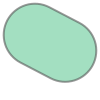

In [11]:
# orig and dest points to wgs
orig_point_wgs = orig_point.to_crs(epsg=4326)
dest_point_wgs = dest_point.to_crs(epsg=4326)

# Combine the dest and orig points
extent_points = orig_point_wgs.append(dest_point_wgs)

# Create a convex hull
graph_extent = extent_points.unary_union.convex_hull

# Conditional buffer to limit network size for walking and cycling
if transport_method == 'walk':
    buffer = 0.01
if transport_method == 'bike':
    buffer = 0.02
if transport_method == 'public':
    buffer = 0.04
if transport_method == 'car':
    buffer = 0.04

graph_extent = graph_extent.buffer(buffer)

# Check results
graph_extent

In [12]:
# Select OSM network type conditionally
if transport_method == 'walk':
    network = 'walk'
if transport_method == 'bike':
    network = 'bike'
if transport_method == 'public':
    network = 'drive'
if transport_method == 'car':
    network = 'drive'

# Get graph
graph = ox.graph_from_polygon(graph_extent, network_type=network)

In [13]:
# Project graph to UTM zone 35
graph_utm = ox.project_graph(graph)
nodes_utm, edges_utm = ox.graph_to_gdfs(graph_utm, nodes=True, edges=True)

# Project points to UTM zone 35
orig_point_utm = orig_point.to_crs(edges_utm.crs)
dest_point_utm = dest_point.to_crs(edges_utm.crs)

<AxesSubplot:>

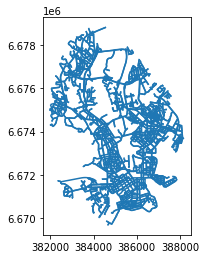

In [14]:
edges_utm.plot()

In [15]:
# Creating GDF with a line column for the route
routes = gpd.GeoDataFrame()
routes['geometry'] = None

# Select origin y and x
orig_yx = (orig_point_utm['geometry'].iloc[0].y, orig_point_utm['geometry'].iloc[0].x)
# Get node id
orig_node_id = ox.get_nearest_node(graph_utm, orig_yx, method='euclidean')
# Get node
orig_node = nodes_utm.loc[orig_node_id]

# Select destination y and x
dest_yx = (dest_point_utm['geometry'].iloc[0].y, dest_point_utm['geometry'].iloc[0].x)
# Get node id
dest_node_id = ox.get_nearest_node(graph_utm, dest_yx, method='euclidean')
# Get node
dest_node = nodes_utm.loc[dest_node_id]

# Only calculate route when the start and destination node IDs are different
if dest_node_id != orig_node_id:
    # Get shortest path
    route = nx.shortest_path(graph_utm, source=orig_node_id, target=dest_node_id, weight='length')
    # Get route nodes
    route_nodes = nodes_utm.loc[route]
    # Construct route line
    route_line = LineString(list(route_nodes.geometry.values))
    # Add line to lines column
    routes.at[0, 'geometry'] = route_line

In [16]:
routes.crs = edges_utm.crs
routes.crs

<Projected CRS: +proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Tests

In [17]:
# Cells to gdf
orig_cell = gpd.GeoDataFrame()
dest_cell = gpd.GeoDataFrame()

orig_cell = grid.loc[grid['YKR_ID']==orig_YKR]
dest_cell = grid.loc[grid['YKR_ID']==dest_YKR]

<AxesSubplot:>

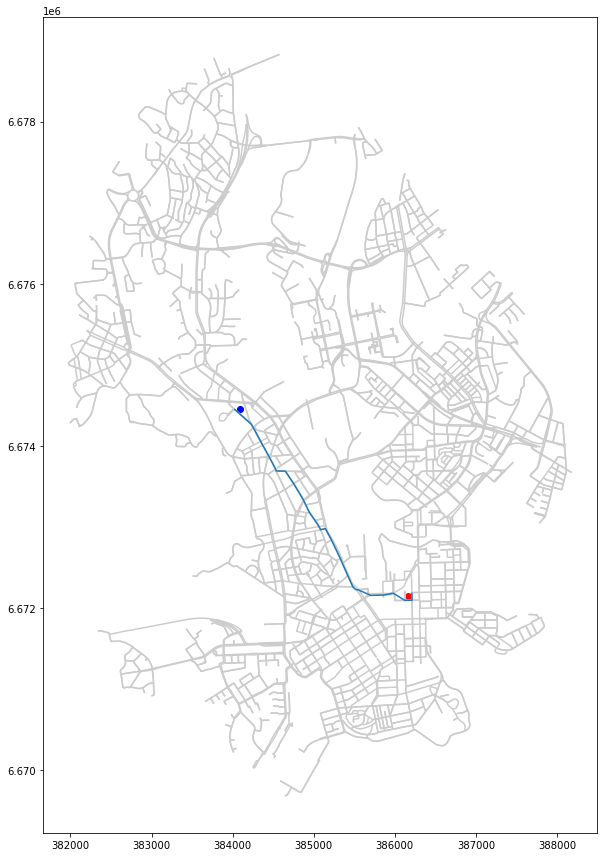

In [18]:
fig, ax = plt.subplots(figsize=(20,15))

#grid.plot(ax=ax, facecolor=[0.9,0.9,0.9], edgecolor=[0.7,0.7,0.7])
#tt_grid.plot(ax=ax, column='pt_r_t', cmap='RdYlBu')

#orig_cell.plot(ax=ax, facecolor=[0.9,0.8,0])
#dest_cell.plot(ax=ax, facecolor=[0,0.7,0.7])
orig_point.plot(ax=ax, color=[0,0,1])
dest_point.plot(ax=ax, color=[1,0,0])

edges_utm.plot(ax=ax, color=[0.8,0.8,0.8])
routes.plot(ax=ax)
#grid_centroids.plot(ax=ax, color=[0,0,0], markersize=1)

## 3.
Visual

In [19]:
routes_wm = routes.to_crs(epsg=3857)
routes_wgs = routes.to_crs(epsg=4326)
orig_point_wm = orig_point.to_crs(epsg=3857)
dest_point_wm = dest_point.to_crs(epsg=3857)

In [20]:
orig_point_wgs_yx = [orig_point_wgs['geometry'].iloc[0].y, orig_point_wgs['geometry'].iloc[0].x]

dest_point_wgs_yx = [dest_point_wgs['geometry'].iloc[0].y, dest_point_wgs['geometry'].iloc[0].x]

route_centroid_wgs_yx = [routes_wgs.centroid.y, routes_wgs.centroid.x]

<ipython-input-20-3471ef62ff05>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  route_centroid_wgs_yx = [routes_wgs.centroid.y, routes_wgs.centroid.x]


In [21]:
routes_wm.at[0, 'travel_time'] = travel_time
routes_wm

,geometry,travel_time
0,"LINESTRING (2772792.208 8442254.636, 2773154.4...",18.0


In [25]:
# Create map instance
m = folium.Map(
    # Background map
    tiles='CartoDB positron',
    overlay=True,
    control_scale=True
)


# Add the route line to the map with quite counter-intuitive syntax
folium.Choropleth(
    routes_wm[routes_wm.geometry.length>1],
    line_weight=3,
    line_color='cadetblue'
).add_to(m)


# Define tooltips and popups
orig_tooltip = 'Origin (click for info)'
dest_tooltip = 'Destination (click for info)'
route_tooltip = 'Shortest route (click for info)'

orig_popup = str(orig_address)+'<br><br>Departure time:'+str(time_now)
dest_popup = str(dest_address)+'<br><br>Estimated arrival time:'+str(time_now)

# Add markers

# Origin
folium.Marker(
    orig_point_wgs_yx,
    popup=orig_popup,
    tooltip=orig_tooltip,
    icon=folium.Icon(icon='arrow-up', color='cadetblue')
).add_to(m)

# Destination
folium.Marker(
    dest_point_wgs_yx,
    popup=dest_popup,
    tooltip=dest_tooltip,
    icon=folium.Icon(icon='arrow-down', color='red')
).add_to(m)

# Display route info
folium.features.GeoJson(routes_wm,
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':50},
                        tooltip=route_tooltip,
                        popup=folium.features.GeoJsonPopup(fields=['travel_time'],
                                                            aliases = ['Travel time (min):'],
                                                            labels=True,
                                                            sticky=False)
                       ).add_to(m)

# Automatically center and zoom the map to the route 
m.fit_bounds([orig_point_wgs_yx, dest_point_wgs_yx]) 

# Display map
m